# Praca Domowa 2

Indywidualnie, nauczyć i wyjaśnić wybrany **model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji** w `torch` na wybranym zbiorze danych zawierającym: **ponad 5000 zdjęć** o rozmiarze **ponad 128x128** przynależących do **ponad 5 klas**. Powstały raport w formatach `.ipynb` oraz `.html` powinien zawierać **wnioski z przeprowadzonej analizy**.

- ~~do 2 punktów uzyskuje się za wytrenowanie skutecznego i nieprzeuczonego modelu CNN (pokazać uczenie na zbiorze treningowym i testowym),~~
- ~~do 2 punktów uzyskuje się za wizualizację 6+ wybranych zdjęć, a dla każdego z nich po 3+ wybranych wyjaśnień (algorytmów jest wiele, ale może być też analiza parametrów danej metody),~~
- ~~do 2 punktów uzyskuje się za analizę wyjaśnień błędnie zaklasyfikowanych zdjęć,~~
- ~~do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu),~~
- do 2 punktów można uzyskać za dodatkowe ciekawe wyniki i eksperymenty związane z wyjaśnianiem CNN i klasyfikacji zdjęć.

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

Deadline: 13 kwietnia 23:59. Na zajęciach 14 kwietnia wybrane osoby krótko zaprezentuje swoje wyniki.

Pracę zgłaszamy poprzez PR o tytule [PD3] Imię Nazwisko do folderu `homeworks/pd3/imię_nazwisko`.

# Dataset - Intel Image Classification

Source: [Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

Description (from Kaggle): This is image data of Natural Scenes around the world. This Data contains around 25k images of size 150x150 distributed under 6 categories.

To limit the size of the dataset, I will only use the first 1000 images from each class for training and first 200 images from each class for testing.

## Imports etc

Dataset downloading copied from [here](https://colab.research.google.com/github/siddarth99/Intel_multiclass_image_classification/blob/master/intel_image_classifier.ipynb#scrollTo=uUTK9FUOusWg).

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download 'puneet6060/intel-image-classification'

 98% 341M/346M [00:01<00:00, 246MB/s]
100% 346M/346M [00:01<00:00, 234MB/s]


In [ ]:
%%capture
!unzip intel-image-classification.zip
!unzip seg_pred.zip
!unzip seg_test.zip
!unzip seg_train.zip

In [ ]:
import cv2 
import os
import numpy as np 
from sklearn.utils import shuffle
import pandas
from collections import Counter
import matplotlib.pyplot as plt 
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

labels_dict = {'buildings' : 0,
              'forest' : 1,
              'glacier' : 2,
              'mountain' : 3,
              'sea' : 4,
              'street' : 5 }
labels_dict_reversed = {v:k for k,v in labels_dict.items()}

TRAIN_PATH = "seg_train/seg_train"
TEST_PATH = "seg_test/seg_test"

## Reading and checking data

First, a scatterplot of image width x height is made to see if there are any outliers. After inspection it turns out that all images has the same width but vary in height from ~75 up to 150, where 150 is most often.

In [ ]:
# inspired by: https://colab.research.google.com/github/siddarth99/Intel_multiclass_image_classification/blob/master/intel_image_classifier.ipynb#scrollTo=uUTK9FUOusWg
def test_available_data(directory):
    labels = []
    heights = []
    widths = []
    for dir in os.listdir(directory):
        label = -1
        if dir in labels_dict.keys():
            label = labels_dict[dir]
        for image_dir in os.listdir(directory +"//"+ dir):
            image = cv2.imread(directory +"//"+ dir + "//"+ image_dir)
            h, w, _ = image.shape
            heights.append(h)
            widths.append(w)
            labels.append(label)
    plt.scatter(widths, heights, alpha=0.1)
    plt.title("Scatterplot of image sizes in " + directory)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

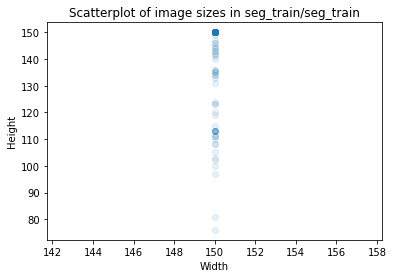

In [ ]:
test_available_data(TRAIN_PATH)

Due to the constraint of minimum image size being greater than 128x128, some images need either to be resized or removed from the dataset. In this notebook, all images will be resized to 150x150 (which is greater than 128x128, but also is unified across all available photos).

To limit the size of the dataset, we will only use the first 1000 images for training and first 200 images for testing, for each class.

In [ ]:
# source: https://colab.research.google.com/github/siddarth99/Intel_multiclass_image_classification/blob/master/intel_image_classifier.ipynb
def get_images(directory, count=1000):
    images = []
    labels = []    
    for dir in os.listdir(directory):
        label = -1
        image_per_class_counter = 0
        if dir in labels_dict.keys():
            label = labels_dict[dir]
        for image_dir in os.listdir(directory +"//"+ dir):
            image = cv2.imread(directory +"//"+ dir + "//"+ image_dir)
            image = cv2.resize(image, (150,150)) # resizing
            image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
            images.append(image)
            labels.append(label)
            if image_per_class_counter >= count:
              break
            image_per_class_counter += 1
    return shuffle(images, labels)

In [ ]:
images, labels = get_images(TRAIN_PATH)

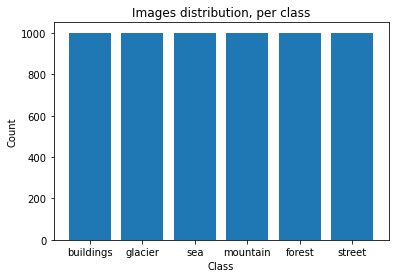

In [ ]:
counts = Counter([labels_dict_reversed[label_num] for label_num in labels])
keys = counts.keys()
values = counts.values()
plt.bar(keys, values)
plt.title("Images distribution, per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Time to create a dataloader.

In [ ]:
labels_t = torch.Tensor(labels).to(DEVICE)
del labels

In [ ]:
images_t = torch.Tensor(np.array(images)).to(DEVICE).permute([0,3,1,2])
del images

In [ ]:
dataset_train = torch.utils.data.TensorDataset(images_t, labels_t)

In [ ]:
torch.save(dataset_train, "dataset_train.pth")

In [ ]:
!cp /content/dataset_train.pth /content/drive/MyDrive/dataset_train.pth

In [ ]:
!cp /content/drive/MyDrive/dataset_train.pth /content/dataset_train.pth

In [ ]:
dataset_train = torch.load("dataset_train.pth")

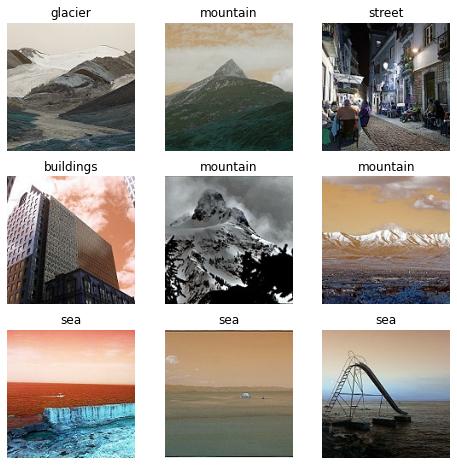

In [ ]:
# source: https://jovian.ai/sahareshubhanshu/pytorch-basics/v/5#C18
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict_reversed[label.int().item()])
    plt.axis("off")
    plt.imshow(img.cpu().permute([1,2,0]).squeeze(), cmap="gray")
plt.show()

Reading test data too.

In [ ]:
images, labels = get_images(TEST_PATH, count=200)
labels_t = torch.Tensor(labels).to(DEVICE)
del labels
images_t = torch.Tensor(np.array(images)).to(DEVICE).permute([0,3,1,2])
del images
dataset_test = torch.utils.data.TensorDataset(images_t, labels_t)

In [ ]:
torch.save(dataset_test, "dataset_test.pth")

In [ ]:
!cp /content/dataset_test.pth /content/drive/MyDrive/dataset_test.pth

In [ ]:
!cp /content/drive/MyDrive/dataset_test.pth /content/dataset_test.pth

In [ ]:
dataset_test= torch.load("dataset_test.pth")

# Training ResNet18

Last part of the network is: `Flatten > Linear(512, 128) > ReLU > Dropout > Linear(128, 6)`.

## Helper functions from previous labs

In [ ]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product
import pandas as pd
import time
from collections import OrderedDict
import json
from IPython.display import clear_output

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    self.tb.add_scalar('Accuracy_test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [ ]:
import torch.nn as nn
def searching_function(params2, output_name, return_model=False):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params2):
    
    # if params changes, following line of code should reflect the changes too
    network = torchvision.models.resnet18(pretrained=False).to(DEVICE)
    network.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 6))

    loader_test = torch.utils.data.DataLoader(dataset_test, batch_size =run.batch_size,shuffle=True,num_workers=2)
    loader = torch.utils.data.DataLoader(dataset_train, batch_size =run.batch_size,shuffle=True,num_workers=2)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader, loader_test)
    for epoch in range(epochs):
      
      m.begin_epoch()
      
      for batch in loader_test:

        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        m.track_num_correct_test(preds, labels)


      for batch in loader:
        
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = network(images)
        loss = F.cross_entropy(preds, labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()

    # when all runs are done, save results to files
    m.save(output_name)
    if return_model == True:
      return network

## Training

(just over 30 minutes on i5-10210u CPU)

In [ ]:
params = OrderedDict(
    lr = [0.001],
    batch_size = [100],
    shuffle = [True],
)
epochs = 5
trained_model = searching_function(params, 'results_1', return_model=True)

run  epoch      loss  accuracy  accuracy_test  epoch duration  \
0    1      1  1.022769  0.596737       0.157546      355.454128   
1    1      2  0.760359  0.725941       0.674129      372.317818   
2    1      3  0.627161  0.780886       0.763682      392.955328   
3    1      4  0.569816  0.804362       0.776949      412.185026   
4    1      5  0.509154  0.827173       0.805141      413.017782   

   run duration     lr  batch_size  shuffle  
0    367.957761  0.001         100     True  
1    742.949225  0.001         100     True  
2   1138.686169  0.001         100     True  
3   1553.934711  0.001         100     True  
4   1970.057472  0.001         100     True

In [ ]:
acc_train = [0.596737,0.725941,0.780886,0.804362,0.827173]
acc_test = [0.157546,0.674129,0.763682,0.776949,0.805141]

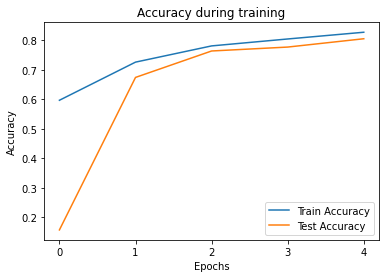

In [ ]:
plt.plot(acc_train, label="Train Accuracy")
plt.plot(acc_test, label="Test Accuracy")
plt.legend()
plt.title("Accuracy during training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 5, 1.0))
plt.show()

## Exporting/importing model

In [ ]:
PATH = './trained_5.pth'
torch.save(trained_model.state_dict(), PATH)

In [ ]:
PATH = './trained_5.pth'
read_from_file_model = torchvision.models.resnet18(pretrained=False).to(DEVICE)
read_from_file_model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 6))
read_from_file_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
!cp /content/drive/MyDrive/trained_5.pth /content/trained_5.pth

## Importing model and datasets from GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2 
import os
import numpy as np 
from sklearn.utils import shuffle
import pandas
from collections import Counter
import matplotlib.pyplot as plt 
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
  DEVICE = "cpu" 
else:  
  DEVICE = "cpu" 

labels_dict = {'buildings' : 0,
              'forest' : 1,
              'glacier' : 2,
              'mountain' : 3,
              'sea' : 4,
              'street' : 5 }
labels_dict_reversed = {v:k for k,v in labels_dict.items()}

TRAIN_PATH = "seg_train/seg_train"
TEST_PATH = "seg_test/seg_test"

In [ ]:
!cp /content/drive/MyDrive/trained_5.pth /content/trained_5.pth

In [ ]:
PATH = './trained_5.pth'
read_from_file_model = torchvision.models.resnet18(pretrained=False).to(DEVICE)
read_from_file_model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 6))
read_from_file_model.load_state_dict(torch.load(PATH))
network = read_from_file_model

In [ ]:
!cp /content/drive/MyDrive/dataset_train.pth /content/dataset_train.pth

In [ ]:
!cp /content/drive/MyDrive/dataset_test.pth /content/dataset_test.pth

In [ ]:
dataset_train = torch.load("dataset_train.pth",map_location=torch.device('cpu'))

In [ ]:
dataset_test= torch.load("dataset_test.pth",map_location=torch.device('cpu'))

# Analysis of model's predictions - confusion matrix
Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 100,num_workers=2)
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(dataset_test.tensors[1])
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(dataset_test))

total correct: 927
accuracy: 0.7686567164179104


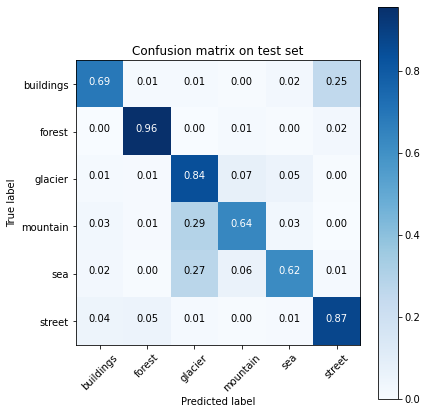

In [ ]:
# Source: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(dataset_test.tensors[1], test_preds.argmax(dim=1))
classes = list(labels_dict.keys())
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes,title='Confusion matrix on test set')

# Analysis of model's predictions - explanations of correct predictions

First, a sample of 5 photos is sampled from correctly classified test data. Then, a total of 6 photos is selected, 1 from each class.

Finally, for each image thera are 3 methods tested - LIME, IG and SHAP.

Results are after each photo and at the bottom of this section.

In [ ]:
def plot_single_photo(img_label):
    img, label = img_label
    plt.figure(figsize=(4,4))
    plt.title(labels_dict_reversed[label.int().item()])
    plt.axis("off")
    plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()

def plot_six_at_once(imgs_labs):
    figure = plt.figure(figsize=(12, 16))
    for i in range(1, len(imgs_labs) + 1):
        img, label = imgs_labs[i-1][0], imgs_labs[i-1][1]
        figure.add_subplot(1, len(imgs_labs), i)
        plt.title(labels_dict_reversed[label.int().item()])
        plt.axis("off")
        plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()

def get_photo_correctly_predicted_by_class_and_id(class_num,id,dataset=dataset_test):
    only_correct_predictions = dataset[test_preds.argmax(dim=1).eq(actual_labels)]
    filtered_by_class_dataset = (only_correct_predictions[0][only_correct_predictions[1]==class_num],\
                                 only_correct_predictions[1][only_correct_predictions[1]==class_num])
    return (filtered_by_class_dataset[0][id], filtered_by_class_dataset[1][id])

def plot_random_5_images_from_each_class(dataset=dataset_test):
    # source: https://jovian.ai/sahareshubhanshu/pytorch-basics/v/5#C18
    figure = plt.figure(figsize=(12, 16))
    cols, rows = 5, 6
    only_correct_predictions = dataset[test_preds.argmax(dim=1).eq(actual_labels)]
    for row in range(rows):
        filtered_dataset = (only_correct_predictions[0][only_correct_predictions[1]==row],\
                            only_correct_predictions[1][only_correct_predictions[1]==row])
        for i in range(1, cols * 1 + 1):
            sample_idx = torch.randint(len(filtered_dataset[0]), size=(1,)).item()
            img, label = filtered_dataset[0][sample_idx], filtered_dataset[1][sample_idx]
            figure.add_subplot(rows, cols, i+cols*row)
            plt.title(labels_dict_reversed[label.int().item()] + f" (id:{sample_idx})")
            plt.axis("off")
            plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()

Sample of 5 images from each class.

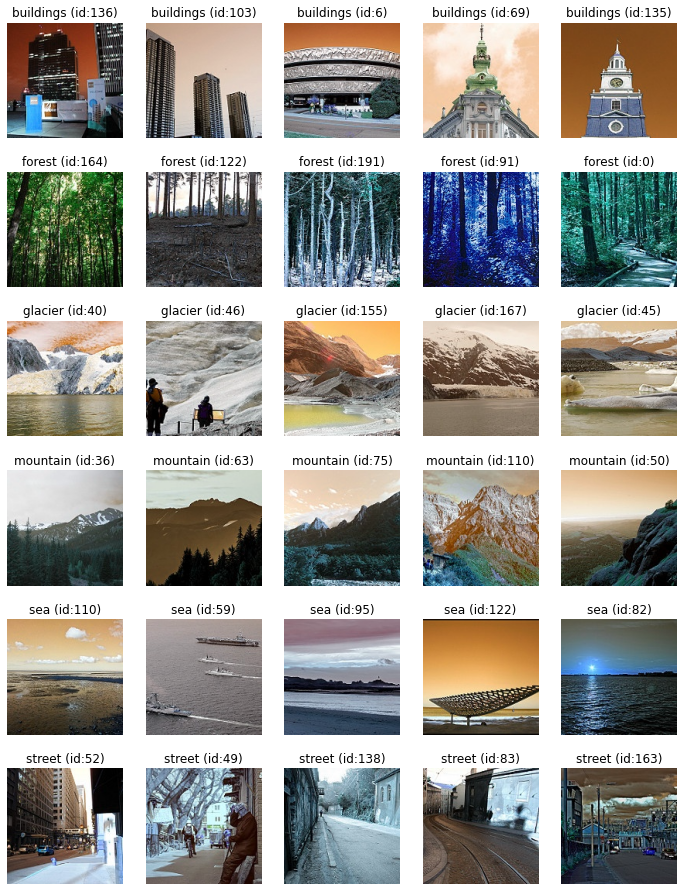

In [ ]:
plot_random_5_images_from_each_class() # do not rerun (cannot preserve random state)

In [ ]:
ph_0 = get_photo_correctly_predicted_by_class_and_id(class_num=0, id=103) # buildings,  visible
ph_1 = get_photo_correctly_predicted_by_class_and_id(class_num=1, id=191) # forest,     visible
ph_2 = get_photo_correctly_predicted_by_class_and_id(class_num=2, id=167) # glacier,    barely visible
ph_3 = get_photo_correctly_predicted_by_class_and_id(class_num=3, id=110) # mountain,   visible
ph_4 = get_photo_correctly_predicted_by_class_and_id(class_num=4, id=82)  # sea,        visible with sun
ph_5 = get_photo_correctly_predicted_by_class_and_id(class_num=5, id=163) # street,     rather visible

Sample of 6 images, 1 from each class, for further experiments.

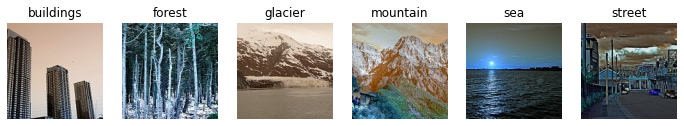

In [ ]:
selected_photos = [ph_0,ph_1,ph_2,ph_3,ph_4,ph_5]
plot_six_at_once(selected_photos)

## Some more installations

In [ ]:
%%capture
!pip install shap captum torchinfo

In [ ]:
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
from captum.attr import KernelShap

In [ ]:
def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def lime_plot_for_photo_id(id, compactness=0.1):
    explainer = Lime(network.double())
    X = selected_photos[id][0]
    ## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
    mask = segmentation.slic(
        X.permute(1, 2, 0).mean(axis=2), 
        n_segments=100, 
        compactness=compactness, 
        start_label=0,
      )
    attr = explainer.attribute(
        X.unsqueeze(0).double(), 
        target=id, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
      )
    show_image_mask_explanation(X, mask, attr[0].mean(axis=0))
    show_attr(attr[0])

In [ ]:
def ig_plot_for_photo_id(id):
    X = selected_photos[id][0].double()
    exp_ig = IntegratedGradients(network.double())
    attr_ig = exp_ig.attribute(
        X.unsqueeze(0),
        target=id
      )
    show_attr(attr_ig[0])

In [ ]:
def shap_plot_for_photo_id(id, kernel_size=14):
    X = selected_photos[id][0].double()
    mask = segmentation.quickshift(
        X.permute(1, 2, 0), 
        kernel_size=kernel_size, 
        max_dist=7, 
        ratio=0.5
      )
    exp_ks = KernelShap(network.double())

    exp_ks = exp_ks.attribute(
        X.unsqueeze(0),
        target=id, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
      )

    show_attr(exp_ks[0])

## Photo 1 - Skyscrapers (class: building)

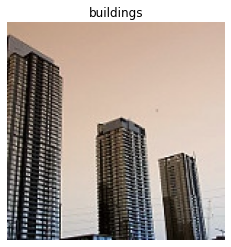

In [ ]:
plot_single_photo(ph_0)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:27<00:00,  7.26it/s]


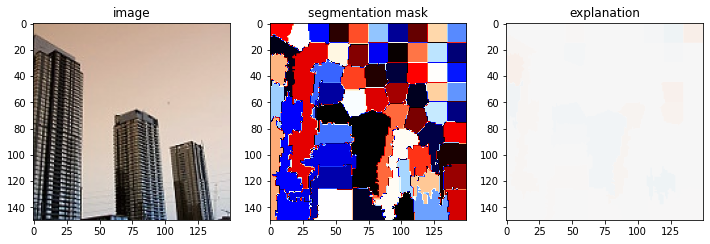

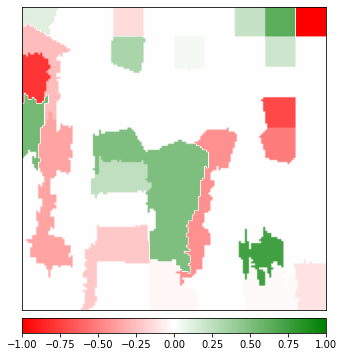

In [ ]:
lime_plot_for_photo_id(0, compactness=0.1)

### Integrated Gradients

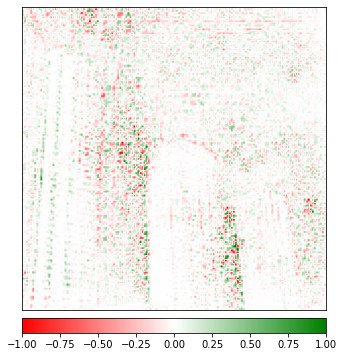

In [ ]:
ig_plot_for_photo_id(0)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s]


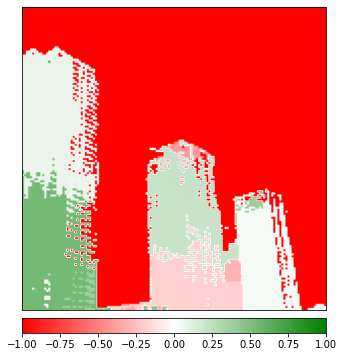

In [ ]:
shap_plot_for_photo_id(0)

Summary:
- lime - random explanations
- ig - random dots with slight shapes of buildings
- shap - distinct features with somewhat green buildings

## Photo 2 - Trees (class: forest)

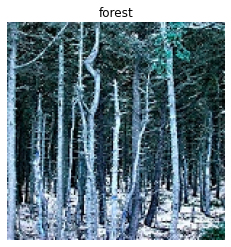

In [ ]:
plot_single_photo(ph_1)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


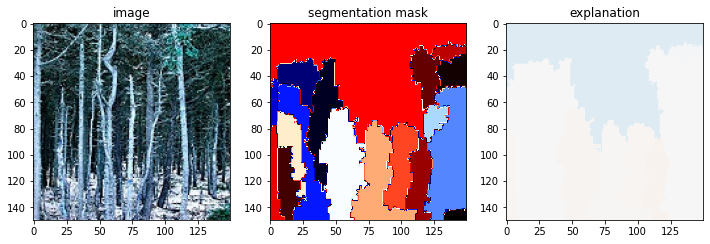

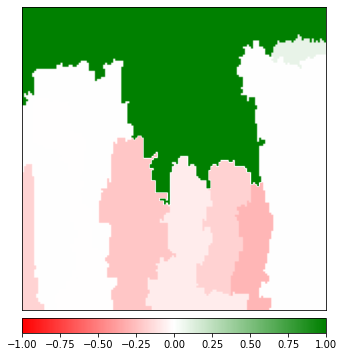

In [ ]:
lime_plot_for_photo_id(1, compactness=0.1)

### Integrated Gradients

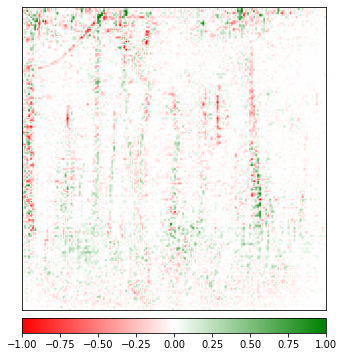

In [ ]:
ig_plot_for_photo_id(1)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


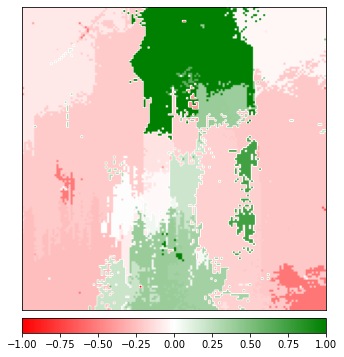

In [ ]:
shap_plot_for_photo_id(1)

Summary:
- lime - top parts of the trees selected - seems fine
- ig - random dots with slight shapes of trunks
- shap - not really

## Photo 3 - Lake, mountains (class: glacier)

The glacier takes a very small portion of the image.

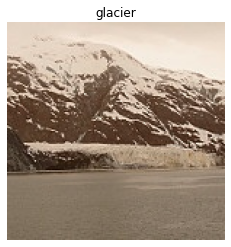

In [ ]:
plot_single_photo(ph_2)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]


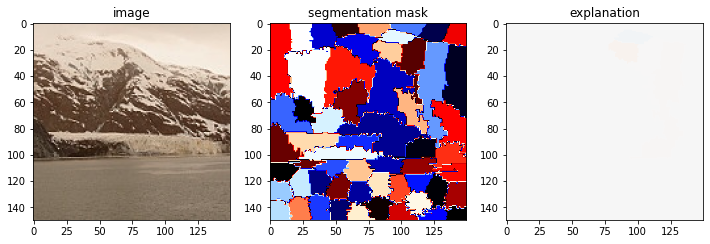

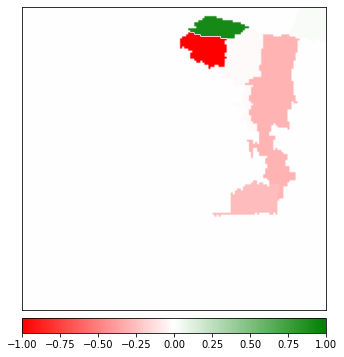

In [ ]:
lime_plot_for_photo_id(2, compactness=0.05)

### Integrated Gradients

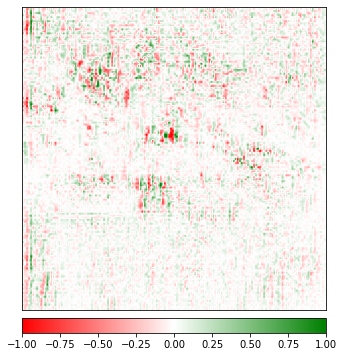

In [ ]:
ig_plot_for_photo_id(2)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:28<00:00,  6.98it/s]


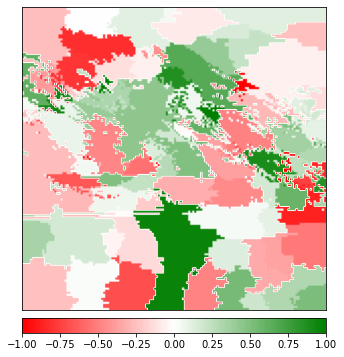

In [ ]:
shap_plot_for_photo_id(2,kernel_size=2)

Summary:
- lime - random explanations (or maybe the glacier is in the sky?)
- ig - random dots without any shapes
- shap - the glacier is a bit red while a part of the lake is green..., nope

## Photo 4 - Mountain (class: mountain)

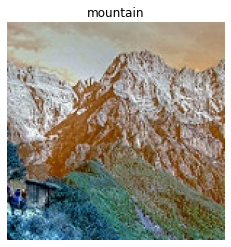

In [ ]:
plot_single_photo(ph_3)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:28<00:00,  7.07it/s]


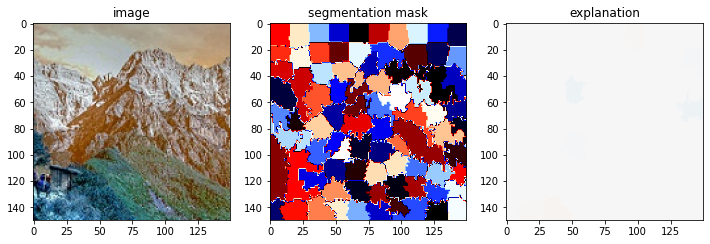

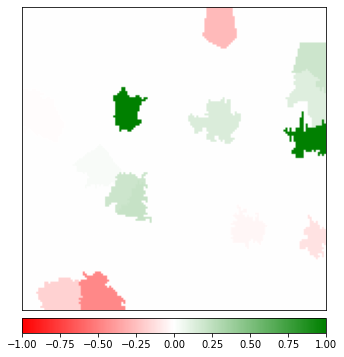

In [ ]:
lime_plot_for_photo_id(3, compactness=0.2)

### Integrated Gradients

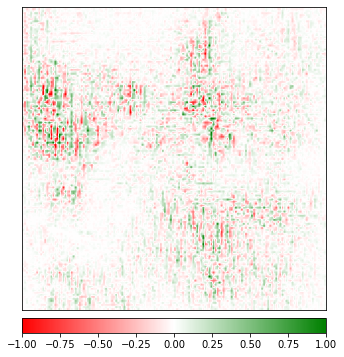

In [ ]:
ig_plot_for_photo_id(3)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:28<00:00,  6.99it/s]


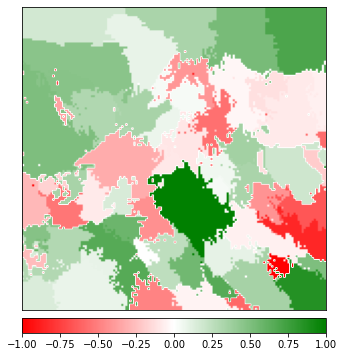

In [ ]:
shap_plot_for_photo_id(3, kernel_size=4)

Summary:
- lime - although the mask resembles the mountain, the explanation does not - only 2 small superpixels are green
- ig - random dots
- shap - the top of the mountain is reddish, but other superpixels are mostly green with the most green superpixel being the forest on the mountain side

## Photo 5 - Sunset at the sea (class: sea)

Is the sun an important element of photos of the sea?

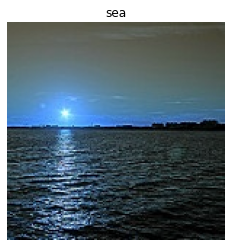

In [ ]:
plot_single_photo(ph_4)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


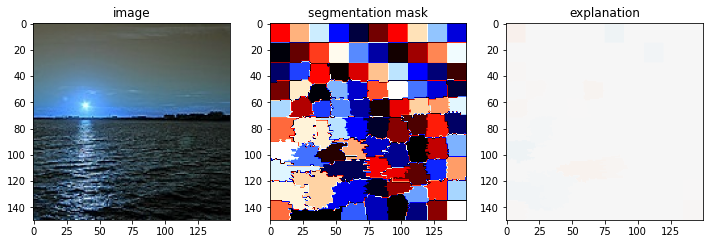

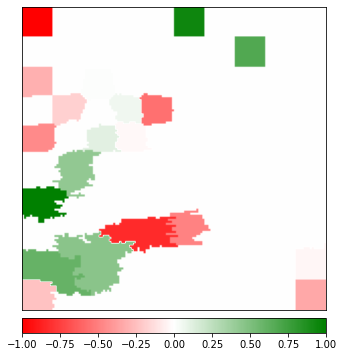

In [ ]:
lime_plot_for_photo_id(4, compactness=0.2)

### Integrated Gradients

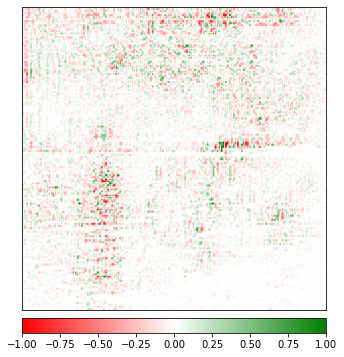

In [ ]:
ig_plot_for_photo_id(4)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:27<00:00,  7.15it/s]


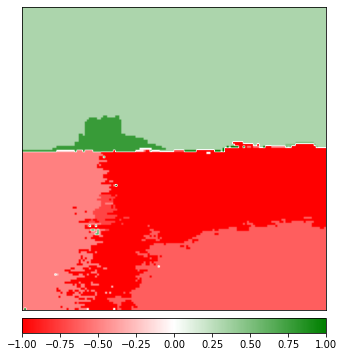

In [ ]:
shap_plot_for_photo_id(4)

Summary:
- lime - random explanations
- ig - random dots
- shap - red sea, green sky, interesting... and the sun being the most green part

## Photo 6 - Street (class: street)


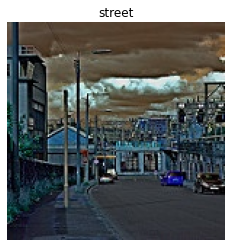

In [ ]:
plot_single_photo(ph_5)

### LIME

Lime attribution: 100%|██████████| 200/200 [00:28<00:00,  6.99it/s]


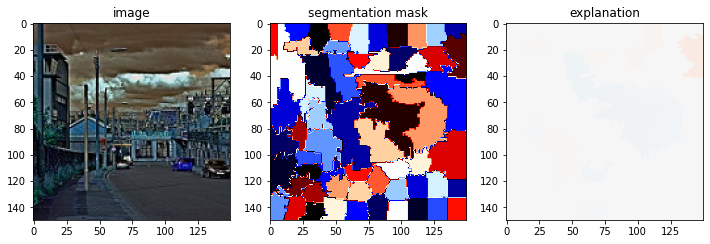

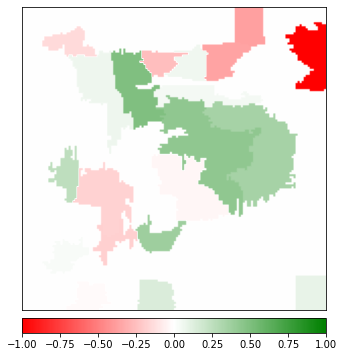

In [ ]:
lime_plot_for_photo_id(5, compactness=0.1)

### Integrated Gradients

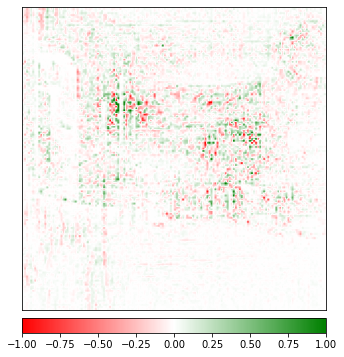

In [ ]:
ig_plot_for_photo_id(5)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:28<00:00,  7.14it/s]


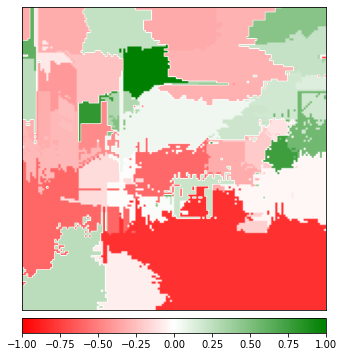

In [ ]:
shap_plot_for_photo_id(5, kernel_size=5)

Summary:
- lime - street not selected
- ig - nope
- shap - well... the street IS selected, BUT is red... nope

## Summary of LIME vs IG vs SHAP on correct predictions

None of the methods explained, why a given image is classified as one class or another. 

LIME may happen to give a good explanation for a human - as in the image with the forest, but for this model the explanations were poor.

IG mostly makes random dots, sometimes resembling contours of the shapes.

Shap sometimes presented strange results - for example the photo with the sea with the sky being green and sea being red. However, the image with buildings (skyscrapers here) was explained very well.

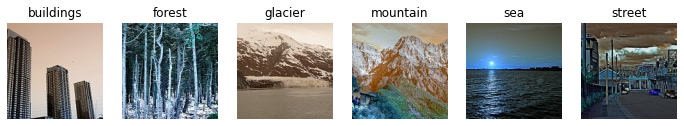

In [ ]:
plot_six_at_once(selected_photos)

A comparison of explanations on the selected 6 photos, 1 for each class. 

|Is it visible for: |  human | LIME | IG | SHAP
| --- | --- | --- |--- |--- |
| Buildings | yes | no	| maybe	| YES		|
| Forest    | yes | YES	| maybe	| no		|
| Glacier| barely | no	| no	| no		|
| Mountain  | yes | no	| no	| maybe		|
| Sea       | yes | no 	| maybe	| no (reverse) |
| Street    | yes | no 	| no 	| no (reverse) |

'Maybe' means that the explanation had something in common with the original image, for example edges or some parts correctly selected. 


'No (reverse)' means that the explanation is perfect but the green should be red and the other way round (best visible in the image 5 - sea, where the sky is green and the sea is red...).

## Possible explanation of differences in explanations

Maybe, the model is less sure of the predicted class for some images than for the others.

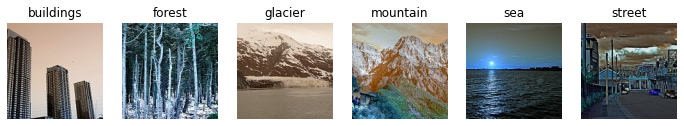

In [ ]:
plot_six_at_once([ph_0, ph_1, ph_2, ph_3, ph_4, ph_5])

In [ ]:
# predictions of the model for the image of the street
network.eval()
network(ph_5[0].unsqueeze(0)).argmax(dim=1)

tensor([5])

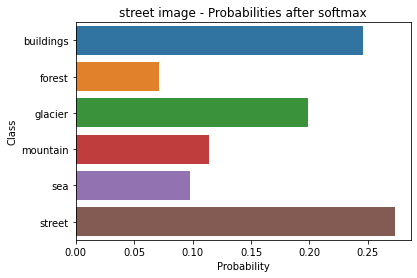

In [ ]:
import seaborn as sns
res_5 = nn.functional.softmax(network(ph_5[0].unsqueeze(0)), dim=1)[0].detach().numpy()
classes = list(labels_dict.keys())
ax = sns.barplot(x=res_5, y=classes)
ax.set_title(classes[5]+" image - Probabilities after softmax")
ax.set_xlabel("Probability")
ax.set_ylabel("Class")
plt.show()

# Analysis of model's predictions - explanations of wrong predictions


## Some functions

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 100,num_workers=2)
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(dataset_test.tensors[1])
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(dataset_test))

total correct: 932
accuracy: 0.7728026533996684


In [ ]:
def get_photo_incorrectly_predicted_by_class_and_id(class_num,id,dataset=dataset_test):
    only_correct_predictions = dataset[test_preds.argmax(dim=1).ne(actual_labels)]
    filtered_by_class_dataset = (only_correct_predictions[0][only_correct_predictions[1]==class_num],\
                                 only_correct_predictions[1][only_correct_predictions[1]==class_num])
    return (filtered_by_class_dataset[0][id], filtered_by_class_dataset[1][id])

def plot_random_5_images_from_each_class(dataset=dataset_test):
    # source: https://jovian.ai/sahareshubhanshu/pytorch-basics/v/5#C18
    figure = plt.figure(figsize=(16, 16))
    cols, rows = 5, 6
    only_incorrect_predictions = dataset[test_preds.argmax(dim=1).ne(actual_labels)]
    only_wrong_predictions_results = test_preds.argmax(dim=1)[test_preds.argmax(dim=1).ne(actual_labels)]

    for row in range(rows):
        filtered_dataset = (only_incorrect_predictions[0][only_incorrect_predictions[1]==row],\
                            only_incorrect_predictions[1][only_incorrect_predictions[1]==row])
        predicted_filtered = only_wrong_predictions_results[only_incorrect_predictions[1]==row]
        for i in range(1, cols * 1 + 1):
            sample_idx = torch.randint(len(filtered_dataset[0]), size=(1,)).item()
            img, label = filtered_dataset[0][sample_idx], filtered_dataset[1][sample_idx]
            pred_label = predicted_filtered[sample_idx]
            figure.add_subplot(rows, cols, i+cols*row)
            plt.title(f"Real: {labels_dict_reversed[label.int().item()]}\nPredicted: {labels_dict_reversed[pred_label.int().item()]} (id:{sample_idx})")
            plt.axis("off")
            plt.subplots_adjust(hspace=0.4)
            plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()

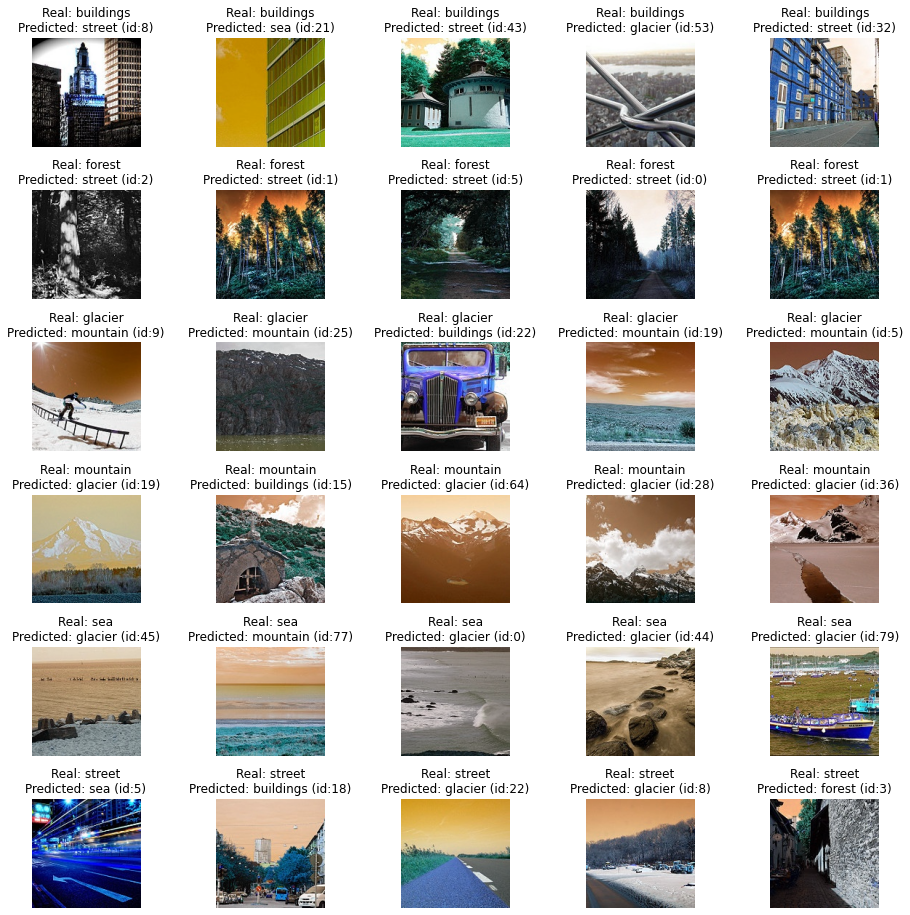

In [ ]:
plot_random_5_images_from_each_class() # titles: {real} / {predicted}

In [ ]:
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
from captum.attr import KernelShap

def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def lime_plot_for_photo_id(photo, class_id, compactness=0.1):
    explainer = Lime(network.double())
    X = photo[0]
    ## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
    mask = segmentation.slic(
        X.permute(1, 2, 0).mean(axis=2), 
        n_segments=100, 
        compactness=compactness, 
        start_label=0,
      )
    attr = explainer.attribute(
        X.unsqueeze(0).double(), 
        target=class_id, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
      )
    show_image_mask_explanation(X, mask, attr[0].mean(axis=0))
    show_attr(attr[0])
	
def ig_plot_for_photo_id(photo, class_id):
    X = photo[0].double()
    exp_ig = IntegratedGradients(network.double())
    attr_ig = exp_ig.attribute(
        X.unsqueeze(0),
        target=class_id
      )
    show_attr(attr_ig[0])

def shap_plot_for_photo_id(photo, class_id, kernel_size=14):
    X = photo[0].double()
    mask = segmentation.quickshift(
        X.permute(1, 2, 0), 
        kernel_size=kernel_size, 
        max_dist=7, 
        ratio=0.5
      )
    exp_ks = KernelShap(network.double())

    exp_ks = exp_ks.attribute(
        X.unsqueeze(0),
        target=class_id, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
      )

    show_attr(exp_ks[0])

def plot_incorrecly_with_titles(imgs_labs, labs_pred):
    figure = plt.figure(figsize=(12, 16))
    for i in range(1, len(imgs_labs) + 1):
        img, label = imgs_labs[i-1][0], imgs_labs[i-1][1]
        figure.add_subplot(1, len(imgs_labs), i)
        plt.title(f"Real: {labels_dict_reversed[label.int().item()]}\nPredicted {labs_pred[i-1]}")
        plt.axis("off")
        plt.imshow(img.cpu().permute([1,2,0]).squeeze())
    plt.show()

## Selected Images

Selected images have wrong predicted label, which is clearly visible for a human.

In [ ]:
ph_0 = get_photo_incorrectly_predicted_by_class_and_id(class_num=0, id=21) # class building, predicted sea
ph_1 = get_photo_incorrectly_predicted_by_class_and_id(class_num=4, id=77) # class sea, predicted mountain
ph_2 = get_photo_incorrectly_predicted_by_class_and_id(class_num=5, id=22) # class street, predicted glacier

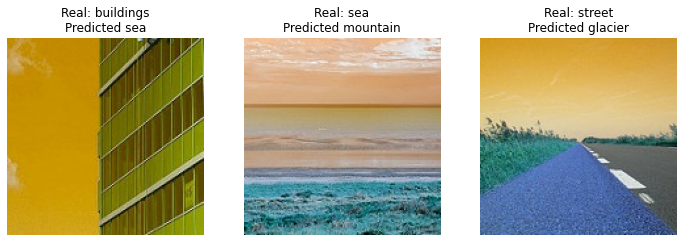

In [ ]:
selected_photos = [ph_0,ph_1,ph_2]
plot_incorrecly_with_titles(selected_photos, ["sea","mountain","glacier"])

Let's test different explanations for each of these photos.

## Photo 1 - Sea (real class: buildings)

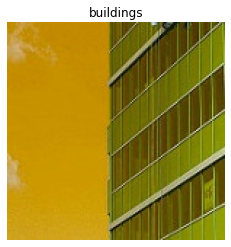

In [ ]:
plot_single_photo(ph_0)
predicted_class_id = 4

### LIME

Lime attribution: 100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


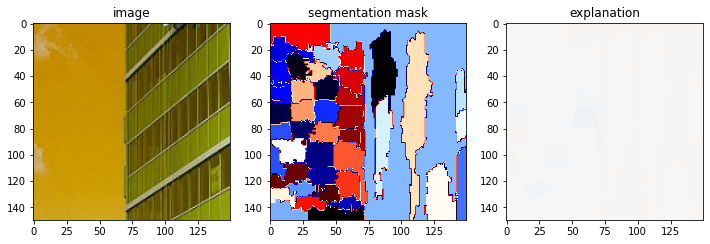

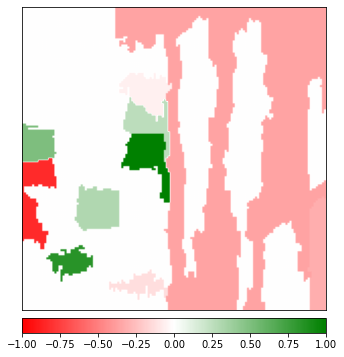

In [ ]:
lime_plot_for_photo_id(ph_0,predicted_class_id, compactness=0.01)

### Integrated Gradients

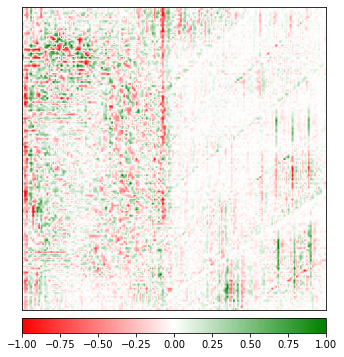

In [ ]:
ig_plot_for_photo_id(ph_0,predicted_class_id)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


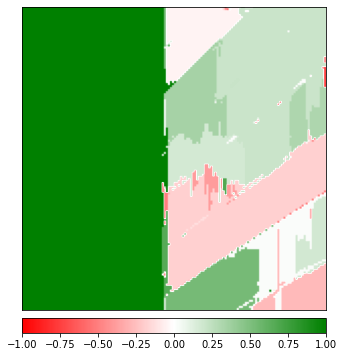

In [ ]:
shap_plot_for_photo_id(ph_0,predicted_class_id)

Summary: As expected, the left hand side of the image (the sky) is marked green by SHAP while the right hand side (the building) is marked red by LIME. So the sky is likely the sea ;P

## Photo 2 - Mountain (real class: sea)

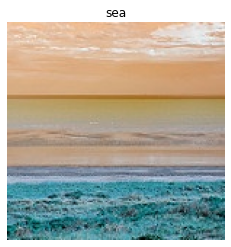

In [ ]:
plot_single_photo(ph_1)
predicted_class_id = 3

### LIME

Lime attribution: 100%|██████████| 200/200 [00:22<00:00,  8.88it/s]


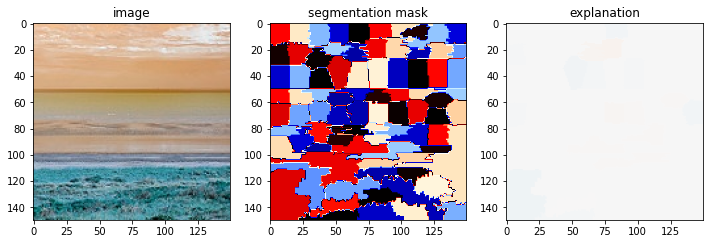

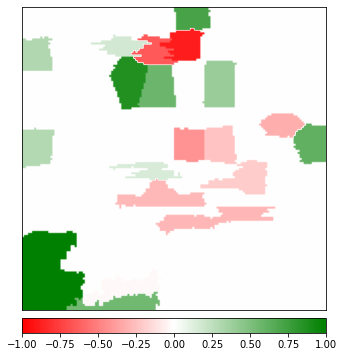

In [ ]:
lime_plot_for_photo_id(ph_1,predicted_class_id, compactness=0.1)

### Integrated Gradients

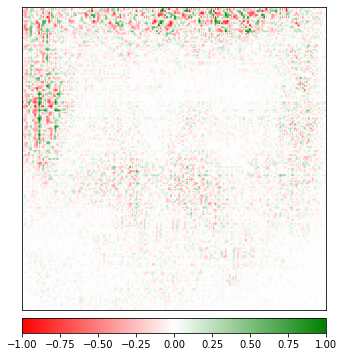

In [ ]:
ig_plot_for_photo_id(ph_1,predicted_class_id )

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:22<00:00,  8.88it/s]


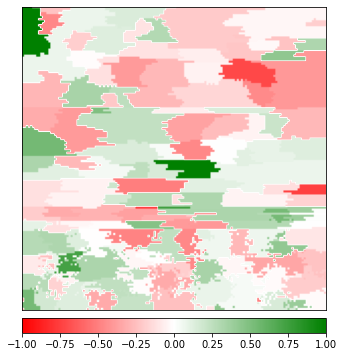

In [ ]:
shap_plot_for_photo_id(ph_1,predicted_class_id, kernel_size=2)

Summary: Nothing interesting, I still do not know which part is responsible for classifying this image as a mountain.

## Photo 3 - Glacier (class: street)

The glacier takes a very small portion of the image.

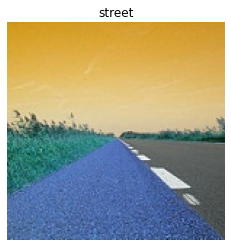

In [ ]:
plot_single_photo(ph_2)
predicted_class_id = 2

### LIME

Lime attribution: 100%|██████████| 200/200 [00:23<00:00,  8.67it/s]


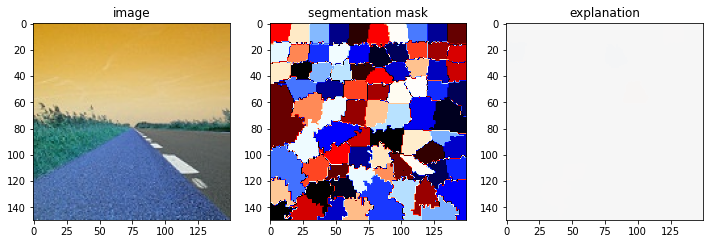

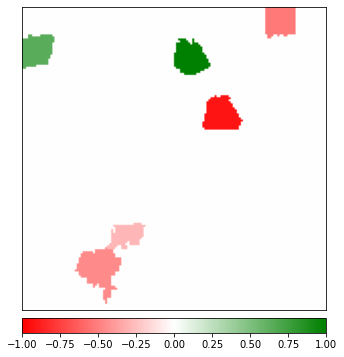

In [ ]:
lime_plot_for_photo_id(ph_2,predicted_class_id, compactness=0.06)

### Integrated Gradients

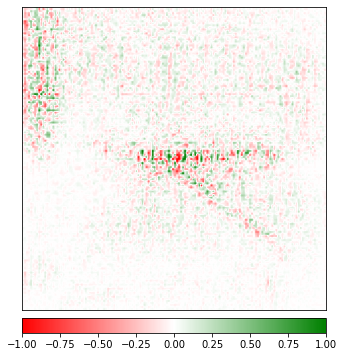

In [ ]:
ig_plot_for_photo_id(ph_2,predicted_class_id)

### SHAP

Kernel Shap attribution: 100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


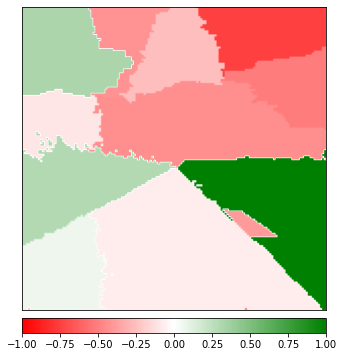

In [ ]:
shap_plot_for_photo_id(ph_2,predicted_class_id,kernel_size=7)

Summary: SHAP has marked the road as a glacier, seems reasonable. Others where random?

## Summary of LIME vs IG vs SHAP on incorrect predictions

Methods:
- SHAP is the most effective method of explanations. 
- LIME gives less accurate explanations (at least from human perspective). 
- I do not understand the meaning of all of those dots in IG.

In terms of explained images:
- the sky (in the image with the building) is marked by SHAP as contributing to classifying this image as sea - makes sense as the sky and a sea may look similar. Also, images with a sea may often contain a clear sky, same as in this photo,
- the mountain (in the image with the sea) is not explained well enough for analysis,
- the glacier (in the image with the street) is kind of explained by SHAP (by selecting the road... maybe some glaciers are black? or are around dark mountains similar to the asphalt in this photo).

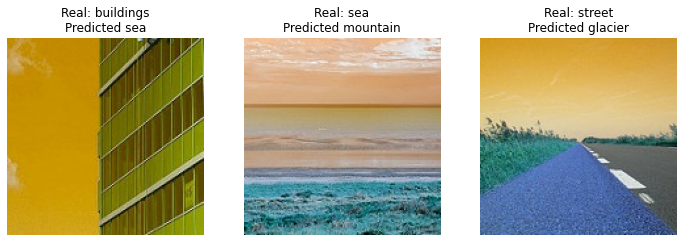

In [ ]:
plot_incorrecly_with_titles([ph_0, ph_1, ph_2], ["sea","mountain","glacier"])

# Summary

The Resnet18 model has been trained on `6000 images` from `6 classes` (1000 images from each class). Images have been reshaped to `150x150`. Source: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). 

The model used for explanations got around 0.8 accuracy on train and test set.

Methods comparison:
- IG is not understood by me, maybe needs some tweaking of parameters...
- LIME sometimes is fine, sometimes not, depeding on the mask,
- SHAP, also depending on the mask, got the best explanations.

Although not every explanation was clear for a human, it may be due to the fact, that the model has around 0.8 accuracy after training for 5 epochs. Surely, after a few more epochs, the accuracy and therefore the explanations would get better.

However, some images could be classified by a human to more than 1 class. For example an image of a street surrounded by buildings - it could be from the class `buildings` as well as from `street`. Others were hard to classify due to poor image quality (blurred, recolorized).

Some missclassified images presented an interesting insights into the inner working of the model - especially the image presenting a building with a clear sky being classified as a sea (the sky was interpreted by the model as a sea according to SHAP). 

## Interesting result

After comparing SHAP explanation of correctly classifying an image belonging to the class `sea` with SHAP explanation of incorrectly classifying an image belonging to the class `buildings`, it is clear that for the model, the sky is the most important part of the images from the class `sea`!
